# 8. 인물 모드 문제점 찾기

## Step 1. 여러 가진 인물모드 해보기

### 1. 배경만 Blur 처리해보기

In [3]:
import cv2
import numpy as np
import os
import tarfile
import urllib #웹에서 데이터 다운로드할때 사용

from matplotlib import pyplot as plt
import tensorflow as tf

In [4]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/img1.jpg' 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(811, 1440, 3)


preprocess는 전처리 run은 세그멘테이션을 하는 함수이다 input tensor를 만들기위해 preprocess함수에서 이미지를 전처리 한다.

In [5]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

사전에 학습된 가중치를 불러온다.

In [6]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


In [7]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(811, 1440, 3) (288, 513, 3) 20


In [8]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

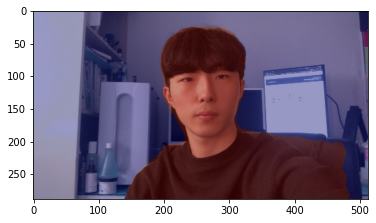

In [9]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

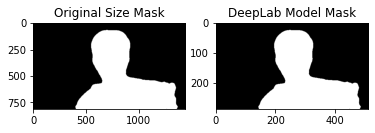

In [10]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

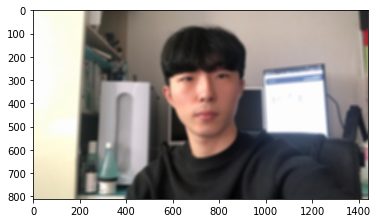

In [12]:
img_orig_blur = cv2.blur(img_orig, (15,15)) #(15,15)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

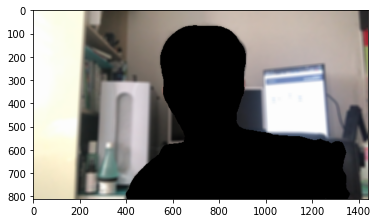

In [13]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

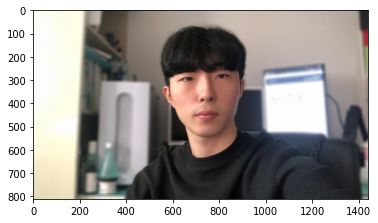

In [58]:
img_save_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/img1_con.jpg'

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)


plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))

cv2.imwrite(img_save_path, img_concat)

plt.show()


### 2. 배경을 다른 이미지로 교체해보기

In [25]:
img_path2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/img2.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig2 = cv2.imread(img_path2) 
print (img_orig2.shape)

(1440, 1440, 3)


In [16]:
img_resized2, seg_map2 = MODEL.run(img_orig2)
print (img_orig2.shape, img_resized2.shape, seg_map2.max())

(1440, 1440, 3) (513, 513, 3) 16


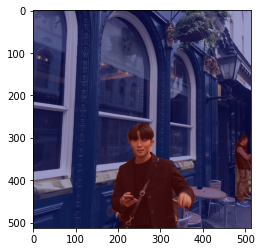

In [17]:
img_show2 = img_resized2.copy()
seg_map2 = np.where(seg_map2 == 15, 15, 0) # 예측 중 사람만 추출
img_mask2 = seg_map2 * (255/seg_map2.max()) # 255 normalization
img_mask2 = img_mask2.astype(np.uint8)
color_mask2 = cv2.applyColorMap(img_mask2, cv2.COLORMAP_JET)
img_show2 = cv2.addWeighted(img_show2, 0.6, color_mask2, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show2, cv2.COLOR_BGR2RGB))
plt.show()

(1440, 1440)


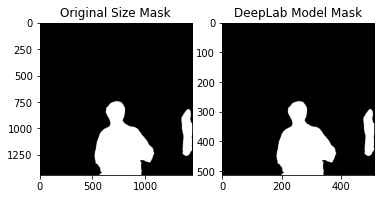

In [21]:
img_mask_up2 = cv2.resize(img_mask2, img_orig2.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up2 = cv2.threshold(img_mask_up2, 128, 255, cv2.THRESH_BINARY)

print(img_mask_up2.shape)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up2, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask2, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

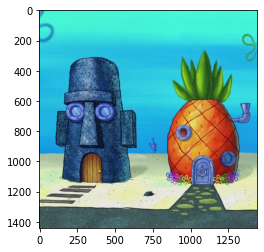

In [20]:
img_backgrd_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/backimage1.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_backgrd = cv2.imread(img_backgrd_path) 
img_backgrd_up = cv2.resize(img_backgrd, img_orig2.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
plt.imshow(cv2.cvtColor(img_backgrd_up, cv2.COLOR_BGR2RGB))
plt.show()

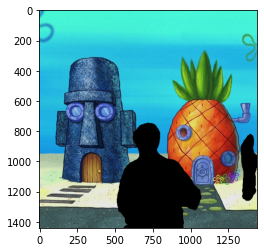

In [22]:
img_mask_color2 = cv2.cvtColor(img_mask_up2, cv2.COLOR_GRAY2BGR)
img_bg_mask2 = cv2.bitwise_not(img_mask_color2)
img_backgrd_spon = cv2.bitwise_and(img_backgrd_up, img_bg_mask2)
plt.imshow(cv2.cvtColor(img_backgrd_spon, cv2.COLOR_BGR2RGB))
plt.show()

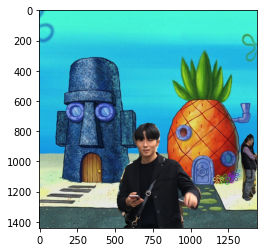

True

In [59]:
img_save_path2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/img2_con.jpg'


img_concat2 = np.where(img_mask_color2 ==255, img_orig2 , img_backgrd_spon)
plt.imshow(cv2.cvtColor(img_concat2, cv2.COLOR_BGR2RGB))
plt.show()


cv2.imwrite(img_save_path2, img_concat2)

### 3. 사람이 아닌 강아지 아웃포커싱 사진만들기

In [46]:
img_path3 = os.getenv('HOME')+'/aiffel/human_segmentation/images/img3.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig3 = cv2.imread(img_path3) 
print (img_orig3.shape)

(1099, 1099, 3)


In [47]:
img_resized3, seg_map3 = MODEL.run(img_orig3)
print (img_orig3.shape, img_resized3.shape, seg_map3.max())

(1099, 1099, 3) (513, 513, 3) 18


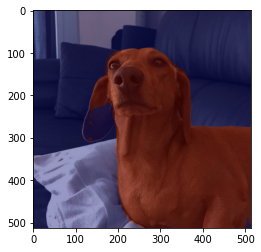

In [48]:
img_show3 = img_resized3.copy()
seg_map3 = np.where(seg_map3 == 12, 12, 0) # 예측 중 강아지만 추출
img_mask3 = seg_map3 * (255/seg_map3.max()) # 255 normalization
img_mask3 = img_mask3.astype(np.uint8)
color_mask3 = cv2.applyColorMap(img_mask3, cv2.COLORMAP_JET)
img_show3 = cv2.addWeighted(img_show3, 0.6, color_mask3, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show3, cv2.COLOR_BGR2RGB))
plt.show()

(1099, 1099)


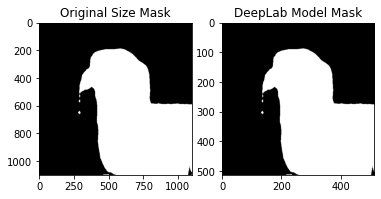

In [49]:
img_mask_up3 = cv2.resize(img_mask3, img_orig3.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up3 = cv2.threshold(img_mask_up3, 128, 255, cv2.THRESH_BINARY)

print(img_mask_up3.shape)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up3, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask3, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

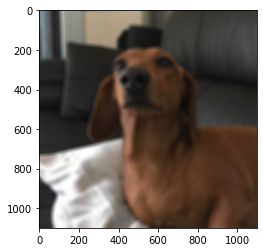

In [55]:
img_orig_blur3 = cv2.blur(img_orig3, (25,25))
plt.imshow(cv2.cvtColor(img_orig_blur3, cv2.COLOR_BGR2RGB))
plt.show()

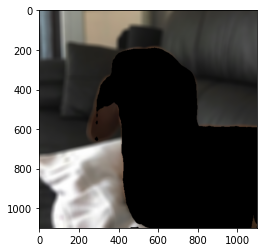

In [56]:
img_mask_color3 = cv2.cvtColor(img_mask_up3, cv2.COLOR_GRAY2BGR)
img_bg_mask3 = cv2.bitwise_not(img_mask_color3)
img_bg_blur3 = cv2.bitwise_and(img_orig_blur3, img_bg_mask3)
plt.imshow(cv2.cvtColor(img_bg_blur3, cv2.COLOR_BGR2RGB))
plt.show()

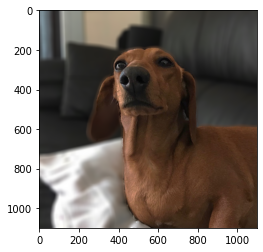

True

In [60]:
img_save_path3 = os.getenv('HOME')+'/aiffel/human_segmentation/images/img3_con.jpg'

img_concat3 = np.where(img_mask_color3 ==255, img_orig3, img_bg_blur3)
plt.imshow(cv2.cvtColor(img_concat3, cv2.COLOR_BGR2RGB))
plt.show()

cv2.imwrite(img_save_path3, img_concat3)

## Step 2. 사진에서 문제점 찾기

In [65]:
text_img_path1 = os.getenv('HOME')+'/aiffel/human_segmentation/images/img1_con_text.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
text_img_orig1 = cv2.imread(text_img_path1) 

text_img_path2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/img2_con_text.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
text_img_orig2 = cv2.imread(text_img_path2) 

text_img_path3 = os.getenv('HOME')+'/aiffel/human_segmentation/images/img3_con_text.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
text_img_orig3 = cv2.imread(text_img_path3) 

In [68]:
print (text_img_orig1.shape)

(450, 799, 3)


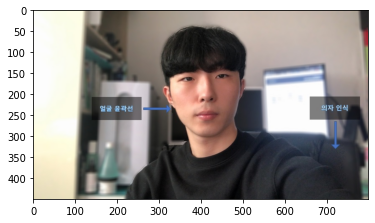

In [69]:
plt.imshow(cv2.cvtColor(text_img_orig1, cv2.COLOR_BGR2RGB))
plt.show()

> - 얼굴 윤곽이 높은 정확도로 사람의 윤곽을 찾지 못했다.
> - 본인 뒤에 있는 검정색 의자의 일부분을 사람이라고 인식했다.

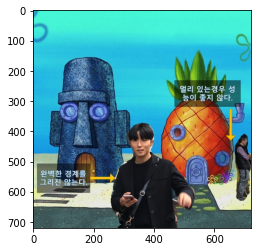

In [71]:
plt.imshow(cv2.cvtColor(text_img_orig2, cv2.COLOR_BGR2RGB))
plt.show()

> - 첫 번째 사진과 마찬가지로 완벽한 사람의 경계를 찾지 못했다.
> - 뒤에 멀리있는 사람도 완전한 경계를 그리지 못했으며, 사람 윤곽을 찾는 성능이 더 낮다.

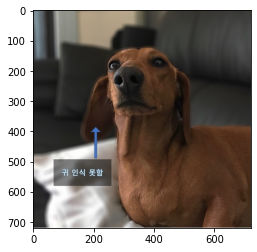

In [73]:
plt.imshow(cv2.cvtColor(text_img_orig3, cv2.COLOR_BGR2RGB))
plt.show()

> - 강아지 귀에 그림자가 생긴 부분을 인식하지 못했다.

##  Step 3. 해결 방법을 제안해 보기

### IR(적외선)을 활용하기

1. 일반적인 RGB 기반 스테레오 깊이 감지 기술은 계산 비용이 많이 들고 텍스처가 낮은 영역에서 문제가 발생할 수 있으며 극도로 낮은 조명 조건에서는 완전히 실패할 수 있다.

2. 하나의 카메라로 형성된 이미지에서 각 픽셀을 둘러싼 영역을 평가하고 두 번째 카메라에서 해당 이미지에서 유사한 영역을 찾는다.

3. 신경 깊이 개선에 따라 인접 타일에서 좋은 깊이 추정치가 반복적으로 전파된다.